In [11]:
from collections import deque
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

COLUMN_WIDTH = 3.25  # Inches
TEXT_WIDTH = 6.299213  # Inches
GOLDEN_RATIO = 1.61803398875
DPI = 300
FONT_SIZE = 8

mpl.rcParams['font.size'] = FONT_SIZE
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times']
# mpl.rcParams['text.usetex'] = True

mpl.rcParams['text.usetex'] = False
from bbutils import BetaBernoulli

In [3]:
category2idx = dict()
idx2category = []
categories = []
observations = []

with open('data/cifar100/predictions.txt', 'r') as f:
    next(f)
    for line in f:
        _, correct, predicted, confidence = line.split()
        
        if predicted not in category2idx:
            category2idx[predicted] = len(category2idx)
            idx2category.append(predicted)
        idx = category2idx[predicted]
        
        categories.append(idx)
        observations.append(correct == predicted)
num_classes = 100

In [4]:
# Try to identify worst class

n = len(observations)
k = num_classes
runs = 100
# pseudo_count = 2
mode = 'min'

active_choices = np.zeros((runs, k, n))
active_thetas = np.zeros((runs, k, n))
random_thetas = np.zeros((runs, k, n))

for r in range(runs):

    # Queue choices for each category
    deques = [deque() for _ in range(k)]
    for category, observation in zip(categories, observations):
        deques[category].append(observation)
    ### THIS IS IMPORTANT ###
    for _deque in deques:
        random.shuffle(_deque)
   ####

    # Random model
    model = BetaBernoulli(k)

#     # Prior
#     # model._params = np.vstack((alpha, beta)).T

    n_success = 0
    total = 0
    for i in range(n):
        while True:
            category = random.randrange(k)
            if len(deques[category]) != 0:
                break
        observation = deques[category].pop()
        model.update(category, observation)
        random_thetas[r, :, i] = model._params[:,0] / (model._params[:,0] + model._params[:,1])
    
    # Queue choices for each category
    deques = [deque() for _ in range(k)]
    for category, observation in zip(categories, observations):
        deques[category].append(observation)
    ### THIS IS IMPORTANT ###
    for _deque in deques:
        random.shuffle(_deque)
   ####

    # Beta Bernoulli model
    model = BetaBernoulli(k)

    # Prior
    # model._params = np.vstack((alpha, beta)).T

    n_success = 0
    total = 0

    for i in range(n):
        theta_hat = model.sample()
        
        if mode == 'max':
            choices = np.argsort(theta_hat)[::-1]
        elif mode == 'min':
            choices = np.argsort(theta_hat)
            
        for j in range(k):
            category = choices[j]
            if len(deques[category]) != 0:
                break
        observation = deques[category].pop()
        model.update(category, observation)
        #beta_bernoulli_outcome[i] = n_success / (total + 1e-13)
        active_thetas[r, :, i] = model._params[:,0] / (model._params[:,0] + model._params[:,1])
        if i > 0:
            active_choices[r, :, i] = active_choices[r, :, i - 1]
        active_choices[r, category, i] += 1

In [5]:
correct = np.zeros(k)
total = np.zeros(k)

for category, observation in zip(categories, observations):
    if observation:
        correct[category] += 1
    total[category] += 1
    
empirical_acc = correct / total
ranked = np.argsort(empirical_acc)[::-1]

squirrel
pear
lizard
oak_tree
lamp
snake
willow_tree
cattle
television
baby


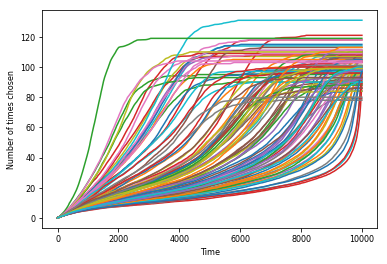

In [15]:
avg_active_choices = np.mean(active_choices, axis=0)

for i in range(k):
    plt.plot(avg_active_choices[i,:])
    plt.xlabel('Time')
    plt.ylabel('Number of times chosen')

top = np.argsort(avg_active_choices[:,-1])[::-1]

for i in top[:10]:
    print(idx2category[i])

In [16]:
most_chosen = np.argmax(active_choices[:, :, :], axis=1)

cutoff = 9

if mode == 'max':
    selection = ranked[:cutoff]
elif mode == 'min':
    selection = ranked[-cutoff:]
    selection = selection[::-1]
    
timestamps = [100, 200, 300, 400, 500]

table = np.zeros((cutoff+1, len(timestamps)))
    
for i, category in enumerate(selection):
    for j, timestamp in enumerate(timestamps):
        table[i,j] = np.mean(most_chosen[:,timestamp] == category)

table[cutoff,:] = 1 - np.sum(table, axis=0)

In [17]:
header = ' ' * 10 + ' '.join('%6i' % x for x in timestamps)
print(header)

for i, row in enumerate(table):
    if i < cutoff:
        category = idx2category[selection[i]]
    else:
        category = 'OTHER'
    category_string = '{:10s}'.format(category)
    num_string = ' '.join('{:.04f}'.format(x) for x in row.tolist())
    print(category_string + num_string)

             100    200    300    400    500
lizard    0.0800 0.1300 0.1500 0.1900 0.2500
seal      0.0200 0.0300 0.0500 0.0300 0.0600
otter     0.0400 0.0500 0.0800 0.1000 0.0900
shrew     0.0300 0.0500 0.0800 0.0800 0.0500
boy       0.0600 0.0400 0.0300 0.0500 0.0600
bear      0.0200 0.0100 0.0200 0.0200 0.0400
woman     0.0400 0.0200 0.0300 0.0400 0.0300
couch     0.0200 0.0100 0.0400 0.0500 0.0900
shark     0.0300 0.0500 0.0400 0.0500 0.0700
OTHER     0.6600 0.6100 0.4800 0.3900 0.2600


In [18]:
random_success = np.mean(np.argmin(random_thetas, axis=1) == selection[0], axis=0)
active_success = np.mean(np.argmin(active_thetas, axis=1) == selection[0], axis=0)

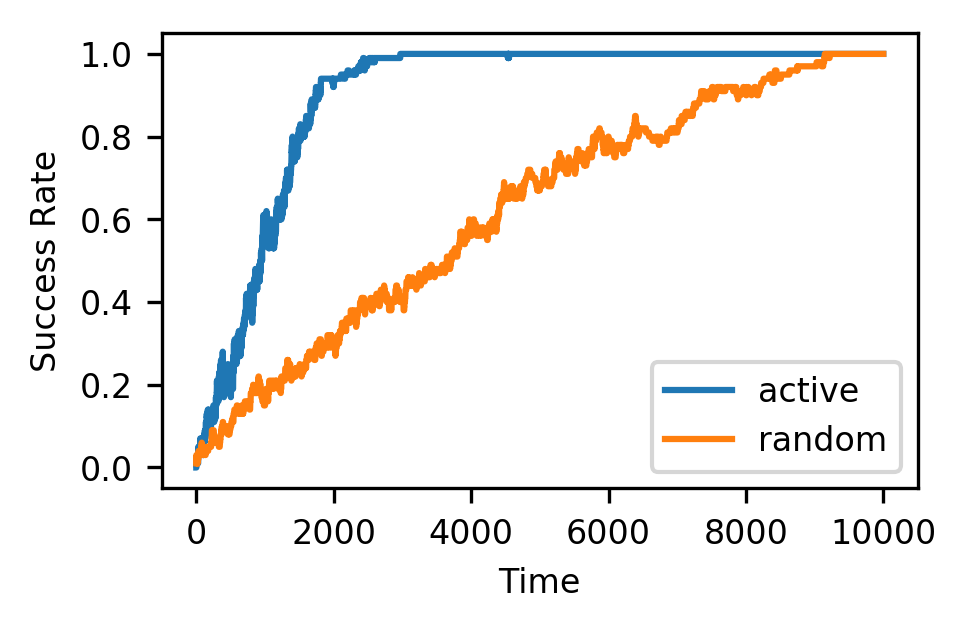

In [21]:
# If labels are getting cut off make the figsize smaller
plt.figure(figsize=(COLUMN_WIDTH, COLUMN_WIDTH / GOLDEN_RATIO), dpi=300)


## PLOT STUFF ##
plt.plot(active_success, label='active')
plt.plot(random_success, label='random')
plt.xlabel('Time')
plt.ylabel('Success Rate')
plt.legend()

# FORMAT STUFF ##
plt.yticks(fontsize=FONT_SIZE)
plt.xticks(fontsize=FONT_SIZE)

plt.savefig("active_cifar100_mode_%s_runs_%d.pdf" % (mode, runs), format='pdf', dpi=300, bbox_inches='tight')